<a href="https://colab.research.google.com/github/blue-create/langlens/blob/main/scripts/elinor_export.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose

This file shows the steps we took to sample and create the annotation dataset.

## Connect with Google drive to access data 

In order to access the data, you first need to create a shortcut of the data folder to your own Gdrive. If you've been granted editing rights, you should be able to edit the content of the folder, i.e. add, move and delete data, create and rename folders, etc.

In [1]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# redirect the working directory of this script to the data folder
#%cd /content/drive/MyDrive/Work/Frontline/data/
%cd /content/drive/MyDrive/data/

/content/drive/MyDrive/data


## Load data

In [3]:
import tqdm as tqdm
from collections import Counter
import os
import pandas as pd
import re 
from ast import literal_eval
import statistics
import matplotlib.pyplot as plt

folder_path = "filtered_4_26"

### Method 1: get csv files 

In [4]:

dfs = []

# loop through files 
for filename in os.listdir(folder_path):
    # if csv file, load and add to dfs  
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        # import csv with text as list object 
        df = pd.read_csv(file_path, index_col=0, converters={"text":literal_eval})
        dfs.append(df)
# combine files in df
df_filtered = pd.concat(dfs, ignore_index=True)

### Method 2: get a csv file

In [ ]:
df_subset = pd.read_csv('sample.csv', encoding='utf-8', index_col=0)

### Method 3: Manually selected dataset of relevant articles
--> ensuring that the dataset only contains relevant articles, espscially for testing

In [ ]:
subset_dv=df_filtered.loc[(11483,14044,62494,49199,11047,14948,10565,31059,58890,20347,55396,56389,5528,18532,59435,8035,27119,12788,59992,21477,10331,26314,45356,61023,31865,48960,44587,17992,14763,60043,20540,4563,13213,6751,43374,41018,38770,24654,21936,29297,1869,33163,60220,61232,57613,48979,33785,51576,8300,7675),:]

## Create a random subset of the data 

In [14]:
# size of subset we want 
number = 50

In [15]:
df_subset = df_filtered.sample(number, random_state=42)

## Adjust format for export

### Methods

In [7]:
# function to count sentences and get summary statistics
def count_sentences(arts):
  sentence_counts=[]
  for art in arts:
    # split on full stop, not when number proceeding, eg. 30. November
    # counting sentences
    sentence_counts=sentence_counts+[len(re.split("(?<!\d)\.", paragraph)) for paragraph in art]
  return {'mean': statistics.mean(sentence_counts),
          'max': max(sentence_counts),
          'min': min(sentence_counts),
          'mode': statistics.mode(sentence_counts)},sentence_counts

In [8]:
def count_words(arts):
  word_counts=[]
  for art in arts:
    # counting words in paragraph
    word_counts=word_counts+[len(paragraph.split()) for paragraph in art]
  return {'mean': statistics.mean(word_counts),
          'max': max(word_counts),
          'min': min(word_counts),
          'mode': statistics.mode(word_counts)},word_counts

In [9]:
def reformat_article(art, min_words=3, max_words=125):
  # remove genios styles 
  art = [re.sub(r'<.*?>', '', x) for x in art]

  # remove new line characters and preceeding whitespaces
  art = [x.strip() for x in art]

  #remove empty paragraphs
  art = [x for x in art if x.strip()]

  #remove paragraphs that are too long
  art = [x for x in art if len(x.split()) < max_words]

  #remove paragraphs that are too short, ie. by default 3 or fewer words
  art = [x for x in art if len(x.split()) >= min_words]  

  return art

### Length of paragraphs before cleaning


#### Using the manually selected dataset

In [ ]:
summary,sentence_count = count_sentences(df_subset["text"])
print("Sentence length before cleaning:", summary)

Sentence length before cleaning: {'mean': 2.0776984460310794, 'max': 34, 'min': 1, 'mode': 1}


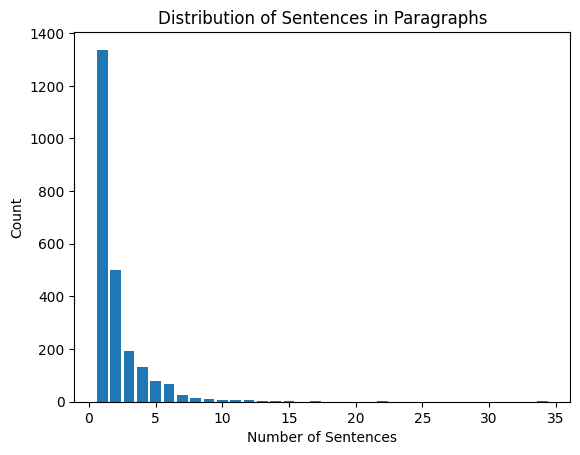

In [ ]:
plt.bar(dict(Counter(sentence_count)).keys(),dict(Counter(sentence_count)).values());
plt.xlabel('Number of Sentences')
plt.ylabel('Count')
plt.title('Distribution of Sentences in Paragraphs');

Observation:
- most paragraphs are rather short
- only few paragraphs exceed 15 sentences


#### Using the entire filtered data set

In [ ]:
summary,sentence_count = count_sentences(df_subset["text"])
print("Sentence length before cleaning:", summary)

Sentence length before cleaning: {'mean': 2.0776984460310794, 'max': 34, 'min': 1, 'mode': 1}


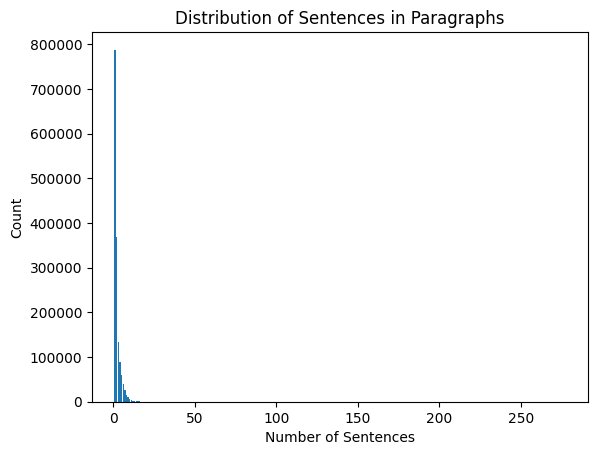

In [ ]:
plt.bar(dict(Counter(sentence_count)).keys(),dict(Counter(sentence_count)).values());
plt.xlabel('Number of Sentences')
plt.ylabel('Count')
plt.title('Distribution of Sentences in Paragraphs');

Checking quantiles

In [ ]:
pd.DataFrame(sentence_count).quantile([0.5,0.9,0.95,0.99])

,0
0.50,1.0
0.90,4.0
0.95,6.0
0.99,10.0


Observations:
- max number fo sentences in paragraph is ~230 
- 90% of all paragraphs have 5 or fewer sentences
- 99% of paragraphs have 10 or fewer sentences

Let's look at articles above the 95%- quantile

In [ ]:
for art in df_filtered["text"].iloc[:10]:
  for paragraph in art:
    # split on full stop, not when number proceeding, eg. 30. November
    if len(re.split("(?<!\d)\.", paragraph))>6:
      print(paragraph)

Onservations:
- long sentence paragraphs are either
  - very short sentences, graphic language, sensational language --> relevant
  - long sentences, descriptive --> too long
--> use number of words instead

### Number of words in articles

#### Using manually selected dataset


In [ ]:
summary,word_count = count_words(df_subset["text"])
print("Sentence length before cleaning:", summary)

Sentence length before cleaning: {'mean': 16.66862662746745, 'max': 610, 'min': 0, 'mode': 1}


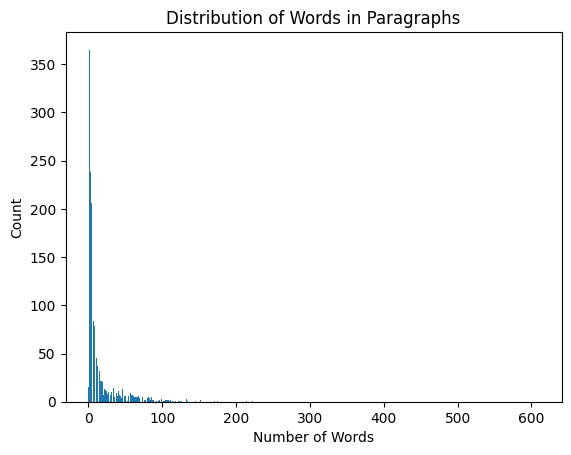

In [ ]:
plt.bar(dict(Counter(word_count)).keys(),dict(Counter(word_count)).values());
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.title('Distribution of Words in Paragraphs');

#### Using entire filtered dataset

In [ ]:
summary,word_count = count_words(df_filtered["text"])
print("Sentence length before cleaning:", summary)

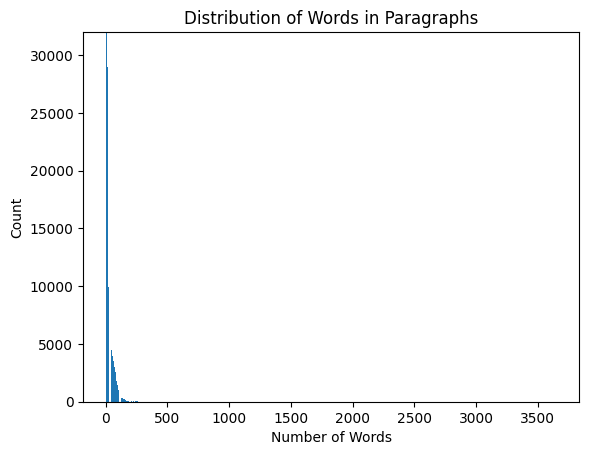

In [ ]:
plt.bar(dict(Counter(word_count)).keys(),dict(Counter(word_count)).values());
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.ylim([0, 32000])
plt.title('Distribution of Words in Paragraphs');

Checking quantiles

In [ ]:
pd.DataFrame(word_count).quantile([0.5,0.9,0.95,0.99])

,0
0.50,7.0
0.90,53.0
0.95,76.0
0.99,127.0


Observations:
- most paragraphs contain less than 50 words
- half of the paragraphs contain <=7 words


Let's look at the 95% quantile paragraphs:

In [ ]:
for art in df_filtered["text"].iloc[:10]:
  for paragraph in art:
    # split on full stop, not when number proceeding, eg. 30. November
    if len(paragraph.split())>75:
      print(paragraph)

Let's look at the 99% quantile paragraphs:

In [ ]:
for art in df_filtered["text"].iloc[:10]:
  for paragraph in art:
    # split on full stop, not when number proceeding, eg. 30. November
    if len(paragraph.split())>127:
      print(paragraph)

Observations:
- 75 words paragraphs are ususlly not too long
- 127+ words are fairly long

--> exclude paragraph if exceeds 125 words

### Cleaning text:
- remove newline characters
- remove paragraphs if too long or short
- remove genios styles 
- remove empty paragraphs

####Using manually created dataset

In [ ]:
subset_dv_clean=subset_dv

In [ ]:
subset_dv_clean["text"] = [ reformat_article(art) for art in subset_dv["text"]]

In [ ]:
summary,word_count = count_words(subset_dv_clean["text"])
print("Sentence length after cleaning:", summary)

Sentence length after cleaning: {'mean': 52.41237113402062, 'max': 122, 'min': 3, 'mode': 3}


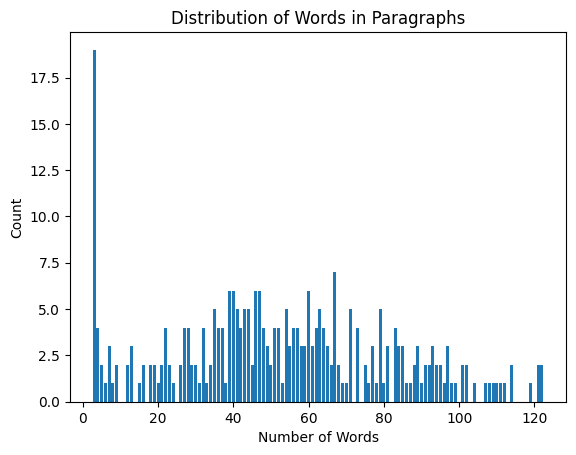

In [ ]:
plt.bar(dict(Counter(word_count)).keys(),dict(Counter(word_count)).values());
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.title('Distribution of Words in Paragraphs');

####Using full dataset

In [16]:
df_subset["text"] = [ reformat_article(art) for art in df_subset["text"]]

In [17]:
summary,word_count = count_words(df_subset["text"])
print("Sentence length after cleaning:", summary)

Sentence length after cleaning: {'mean': 18.800834202294055, 'max': 124, 'min': 3, 'mode': 3}


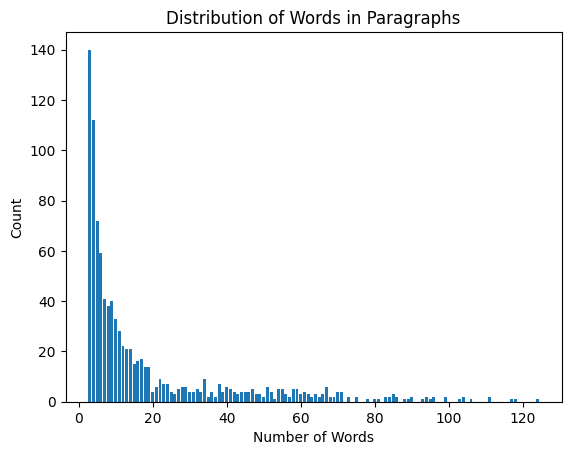

In [18]:
plt.bar(dict(Counter(word_count)).keys(),dict(Counter(word_count)).values());
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.title('Distribution of Words in Paragraphs');

### Explode by paragraphs

In [19]:
# Explode "text" column
df_subset_elinor = df_subset.explode("text")
# Create "artikel_order" column
df_subset_elinor["artikel_order"] = df_subset_elinor.groupby("artikel_id").cumcount() + 1


In [20]:
# remove "empty" articles, that wereremove in the previous step
df_subset_elinor1=df_subset_elinor[df_subset_elinor['text'].notna()] 

### Inspect paragraphs by length

<ipython-input-21-662cd10cfb79>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_elinor1['num_sentences']=[len(re.split("(?<!\d)\.", paragraph)) for paragraph in df_subset_elinor1['text']]


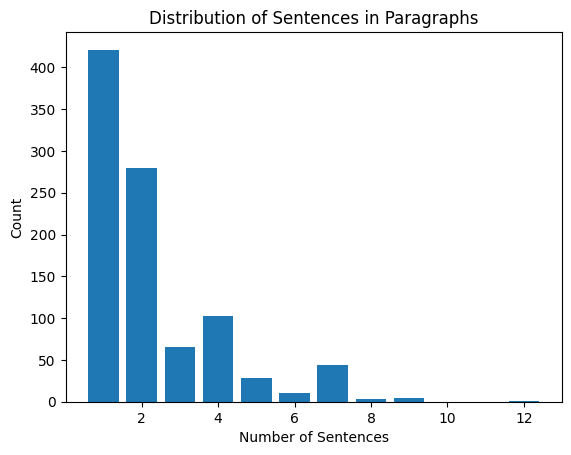

In [21]:
# Get number of sentences
df_subset_elinor1['num_sentences']=[len(re.split("(?<!\d)\.", paragraph)) for paragraph in df_subset_elinor1['text']]

# # # Create a bar chart
plt.bar(df_subset_elinor1['num_sentences'].unique(), df_subset_elinor1['num_sentences'].value_counts())

# # Set axis labels and title
plt.xlabel('Number of Sentences')
plt.ylabel('Count')
plt.title('Distribution of Sentences in Paragraphs');


<ipython-input-22-677a3e46a9d1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_elinor1['num_words']=[len(paragraph.split()) for paragraph in df_subset_elinor1['text']]


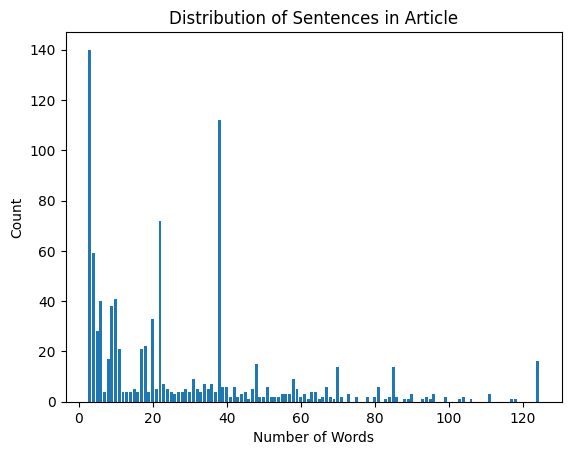

In [22]:
# Get number of Words
df_subset_elinor1['num_words']=[len(paragraph.split()) for paragraph in df_subset_elinor1['text']]

# # # Create a bar chart
plt.bar(df_subset_elinor1['num_words'].unique(), df_subset_elinor1['num_words'].value_counts())

# # Set axis labels and title
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.title('Distribution of Sentences in Article');

### Filter by content

In [102]:
import re
import pandas as pd

In [103]:
# Define regular expressions for weekdays, times, telephone numbers, and street names
weekday_regex = re.compile(r'(Mo|Di|Mi|Do|Fr|Sa|So)\s*[-–]\s*(Mo|Di|Mi|Do|Fr|Sa|So)')
time_regex = re.compile(r'\d{1,2}[:\.]\d{2}\s*bis\s*\d{1,2}[:\.]\d{2}\s*,\s*(Mo|Di|Mi|Do|Fr|Sa|So)\s*,\s*\d{1,2}\.\w+')
phone_regex = re.compile(r'\(?\d{5}\)?[/\s]*\d{1,5}\s*\d{1,5}')
street_regex = re.compile(r'[A-Z][a-z]*-?[A-Za-z]+-?[A-Za-z]*\s*\d+\w*')


In [104]:
# Define a function to remove the unwanted text snippets from a string
def clean_text(text):
    text = weekday_regex.sub('', text)
    text = time_regex.sub('', text)
    text = phone_regex.sub('', text)
    text = street_regex.sub('', text)
    return text.strip()

In [105]:
# Apply the clean_text function to the "text" column of the DataFrame
df_subset_elinor1['clean_text'] = df_subset_elinor1['text'].apply(clean_text)

### Randomly select one paragraph per article

In [23]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
def count_sentences(text):
    return len(nltk.sent_tokenize(text))

In [25]:
df_subset_elinor1['num_sentences'] = df_subset_elinor1['text'].apply(count_sentences)

<ipython-input-25-229108de2b5b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_elinor1['num_sentences'] = df_subset_elinor1['text'].apply(count_sentences)


In [26]:
# Define a function to randomly select one row from each group
def select_random_row(group):
    if group['num_sentences'].max() > 1:
        return group[group['num_sentences'] > 1].sample(n=1)
    else:
        return group.head(1)

In [27]:
# Apply the function to each group and combine the results
random_rows = df_subset_elinor1.groupby('artikel_id').apply(select_random_row).reset_index(drop=True)

In [32]:
final = random_rows[['text']]

## Export as csv

In [33]:
output_path = "elinor"

In [34]:
final.to_csv(output_path+"/annotation_test_05_14.csv", index=False, header = True,
                  encoding = 'utf-8')